# Crystallographic calculations

pyddt provides tools for calculating the atomic scattering amplitude, anomalous scattering factors and structure factors of a crystal.

This step-by-step tutorial aims to show some details on pyddt implementation, particularly the interpolation scheme of tabulated scattering amplitudes and the structure factor formula, besides performing these calculations using the package.

## 1. pyddt implementation

See [Computer Simulation Tools for X-ray Analysis: Scattering and Diffraction Methods](https://link.springer.com/book/10.1007/978-3-319-19554-4) for detailed reference on X-ray scattering theory. 

### 1.1 Atomic scattering factor and resonance amplitude

For an atom with electronic density $\rho_{a}(r)$, the coherent scattering intensity is given by 

$$I \propto |f_{0}(Q) + f'(E) + if''(E)|^{2}$$

where $f_{0} = \text{FT}\{\rho_{a}(r)\}$ is the **atomic scattering factor** and the **resonance amplitude** $f'(E) + if''(E)$ is related to the absorption and fluorescence processes. These values are theoretically calculated for all atoms and significant ions.

pyddt uses the tabulated values from the [International Tables of Crystallography](https://onlinelibrary.wiley.com/doi/book/10.1107/97809553602060000001L), considering the linear interpolation of $f'$ and $f''$ for energies ranging from 1004.16 eV and 70 keV. The parametric equation

$$f_{0}(\text{sin}\theta/\lambda) = f_{0}(Q/4\pi) = \sum_{i=1}^{4}a_{i}e^{-b_{i}\big(\frac{Q}{4\pi}\big)^{2}} + c $$

is employed for Q < 30 $\mathring A$$^{-1}$. $a_{i}, b_{i}$ and $c$ are the Cromer-Mann coefficients.

### 1.2 Structure factor

Given a crystal, the structure factor of the $hkl$ lattice plane is calculated by

$$F_{hkl} = \sum_{a}(f_{0} + f' + if'')_{a}C_{a}e^{-M_{a}}e^{2\pi i (hx_{a}+ly_{a}+lz_{a})} = |F_{hkl}|e^{i\delta_{hkl}}$$

where $a$ summation runs over all atoms inside the unit cell, $C_{a}$ is the occupancy number, and $(x_{a}, y_{a}, z_{a})$ are the fractional coordinates. 

The **isotropic** Debye-Waller factor $$M_{a} = 8\pi^{2}\eta_{a}^{2}\bigg(\frac{\text{sin}\theta}{\lambda}^{2}\bigg) $$
represents the crystal disorder, so that $\eta_{a}$ is the root-mean-square deviation of the $a$-th atom in the direction of $\mathbf{Q}$. 

* pyddt current version doesn't support **anisotropic** thermal motion.

* The structure file (*.in* file) must include the B-factors ($\mathring A$$^2$) of all atoms, defined as 

$$B = 8\pi^{2}\eta_{a}^{2}$$

## 2. Using pyddt

After this brief remarking on the pyddt implementation, let us show how to perform some crystallographic calculations.

### 2.1 Importing packages

Beyond pyddt, we will also use Numpy for generating arrays and matplotlib for plotting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '14'

import sys
sys.path.append('path/to/pyddt')

import pyddt

### 2.2 Atomic scattering factors

Let's calculate the atomic scattering factor of selenium and reciprocal vector $Q=8\pi\; (\mathring A$$^{-1})$.

In [2]:
pyddt.asfQ('Se', 2)  # Q/4π = 2/Å

array([[4.79787017]])

Try it using different atoms, ions, and $Q$ values. The `asfQ` function also works for an array of $Q$ values.

In [3]:
q = np.linspace(0, 5, 10)  # Q/4π
pyddt.asfQ('Se', q)

array([33.9885    , 16.30767336,  7.86524559,  5.59115665,  4.35547504,
        3.55113219,  3.12239028,  2.93518598,  2.86759017,  2.84728523])

What happens for the Na$^{3+}$ ion? 

In [4]:
pyddt.asfQ('Na3+', 2)  

Na3+ is not included in Cromermann factors. Replaced by Na1+


array([[1.03279492]])

pyddt always replaces the ion that isn't available in the tabulated values with the most similar.
A warning always will be show when this kind of replacement happens. 

See [Analyzing structure factor phases in pure and doped single crystals by synchrotron X-ray Renninger scanning](http://scripts.iucr.org/cgi-bin/paper?S1600576713028677) (appendix A) for obtaining the atomic scattering factors of non-tabulated ions by using the available ions.

Lastly, let's visualize the atomic scattering factors as a function of $Q$ using matplotlib. 

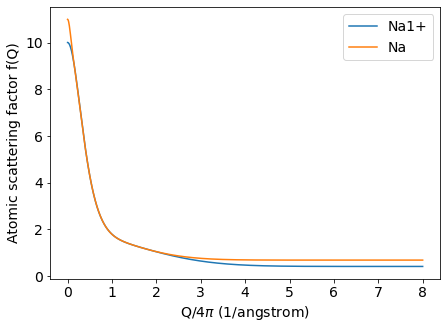

In [5]:
q = np.linspace(0, 8, 1000)

fig = plt.figure(figsize=(7, 5))

plt.plot(q, pyddt.asfQ('Na1+', q), '-', label='Na1+')
plt.plot(q, pyddt.asfQ('Na', q), label='Na')

plt.xlabel(r'Q/4$\pi$ (1/angstrom)')
plt.ylabel('Atomic scattering factor f(Q)')
plt.legend()
plt.show()

### 2.3 Resonance amplitude - anomalous scattering factors

Now, we will show how to obtain the atomic resonance amplitude (also called anomalous scattering factors). The input of `aresE` function is very similar to the `asfQ`. For iron and characteristic radiation, one obtains

In [6]:
pyddt.aresE('Fe', 8048)  # 8048 eV

(-1.1306382948756366+3.1972344171411446j)

Considering a range of energies and copper atom, 

In [7]:
pyddt.aresE('Cu', np.linspace(2000, 8000, 10)) 

array([-0.11975181+6.32684898j,  0.09827547+3.9969607j ,
       -0.05817156+2.75911135j, -0.26933609+2.02224386j,
       -0.49158992+1.54844579j, -0.70484541+1.22527238j,
       -0.92480622+0.99511293j, -1.16733754+0.82516188j,
       -1.4683844 +0.69590195j, -1.91835961+0.59518187j])

What happens for an ion? Try to calculate for Fe$^{2+}$. Is this result physically meaningful?  

In [8]:
pyddt.aresE('Fe2+', 8048)  # 8048 eV

0

The answer is no. The resonance amplitude isn't null for ions, but the tabulated values were only calculated for isolated atoms. 

When calculating the structure factors, **pyddt** will automatically replace the anomalous scattering factor of an ion with the corresponding isolated atom. However, pay attention that this is just an approximation.

Let's take a look at the characteristic behavior of resonance amplitude near the Fe absorption edge.

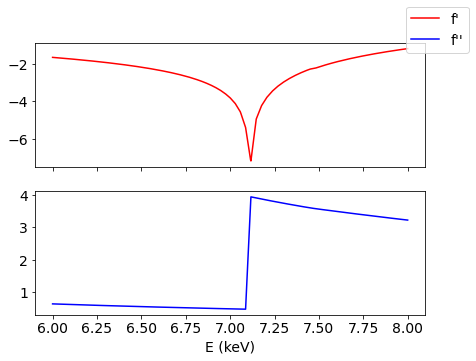

In [9]:
e = np.linspace(6000, 8000, 1000)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

ax1.plot(e/1000, np.real(pyddt.aresE('Fe', e)), 'r-', label="f'")
ax2.plot(e/1000, np.imag(pyddt.aresE('Fe', e)), 'b-', label="f''")

plt.xlabel(r'E (keV)')
fig.legend()
plt.show()

### 2.3 Structure factor

To exemplify the structure factor calculation, let us consider the sodium chloride crystal. You can download its CIF on [Materials Project mp-22862](https://materialsproject.org/materials/mp-22862/). 

`NaCl.cif`


<img align=left src="https://user-images.githubusercontent.com/106104347/187297124-d39c3bb1-c62a-41d7-a11e-a1b7c264b281.png" width="350">

#### 2.3.1 Converting CIF into .in file 

The `Crystal`class requires an *.in* file, so we will convert the CIF into the expected format using the `pyddt.to_in()` function.

In [10]:
pyddt.to_in('NaCl.cif')

In the current folder, two new files are available: `NaCl.in` and `NaCl.struc`. Take a look at them.

The *.in* file presents the atom or ion symbol followed by its fractional coordinates ($x$, $y$ and $z$), occupancy number and B-factor. The first line shows the lattice parameters ($a$, $b$, $c$, $\alpha$, $\beta$ and $\gamma$). Meanwhile, the *.struc* file presents some structural and electronic properties which might be useful for structural modelling.

#### 2.3.2 Crystal object

The next step is generating a `crystal` object.

In [11]:
nacl = pyddt.Crystal('NaCl.in')

Once this object was created, we can check its lattice and structure. 

In [12]:
nacl.structure.lattice

array([ 5.6917,  5.6917,  5.6917, 90.    , 90.    , 90.    ])

In [13]:
nacl.structure.atoms

array(['Na', 'Na', 'Na', 'Na', 'Cl', 'Cl', 'Cl', 'Cl'], dtype='<U32')

In [14]:
nacl.structure.positions

array([[0. , 0. , 0. ],
       [0. , 0.5, 0.5],
       [0.5, 0. , 0.5],
       [0.5, 0.5, 0. ],
       [0.5, 0. , 0. ],
       [0.5, 0.5, 0.5],
       [0. , 0. , 0.5],
       [0. , 0.5, 0. ]])

The `bragg()` method returns the interplanar distance and Bragg angle from beam energy and the Miller indices.

In [15]:
d, th = nacl.bragg(8048, [1, 0, 0])
print('\nE = 8048 eV - hkl = 100')
print('d = ', np.round(d, 2), 'angstrom')
print('Bragg angle = ', np.round(th, 2), 'deg\n')


E = 8048 eV - hkl = 100
d =  5.69 angstrom
Bragg angle =  7.78 deg



The `Fhkl()` method returns the complex structure factor. Feel free to try other energy values and *hkl* indices.

In [16]:
F = nacl.Fhkl(8048, [1, 1, 1])

print(" F = ", np.round(F, 4),
      "\n|F| = ", np.round(np.absolute(F), 4), 
      "\nphase = ", np.round(np.angle(F)*180/np.pi, 4), "deg")

 F =  (-18.6152-2.2587j) 
|F| =  18.7517 
phase =  -173.0818 deg


It's possible to do this calculation for an array of energies or reflections by once.

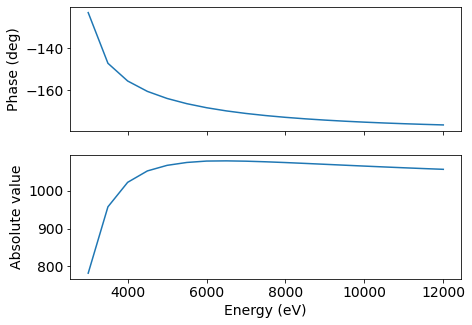

In [17]:
E = np.arange(3000, 12500, 500)  # eV

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

ax1.plot(E, np.angle(nacl.Fhkl(E, [1, 1, 1]))*180/np.pi)
ax2.plot(E, np.absolute(nacl.Fhkl(E, [1, 1, 1]))*180/np.pi)

plt.xlabel('Energy (eV)')

ax1.set_ylabel('Phase (deg)')
ax2.set_ylabel('Absolute value')
plt.show()

In [18]:
F = nacl.Fhkl(8048, [[1, 1, 3], [0, 0, 1]])
print('phase = ', *np.angle(F)*180/np.pi, 'degrees')

phase =  -168.935091990334219 90.000000000000003504 degrees


#### 2.3.3 Structure factor list 

By the end, let us calculate the structure factor of all reflections. 

In [19]:
hkl, f, d = nacl.diffraction(8048)  # Miller indices, structure factors and interplanar distance

In [20]:
hkl

array([[ 0.,  0., -2.],
       [ 0., -2.,  0.],
       [-2.,  0.,  0.],
       ...,
       [-5.,  0., -1.],
       [ 1., -1.,  0.],
       [ 0., -5., -3.]])

In [21]:
d  # angstrom

array([2.84585   , 2.84585   , 2.84585   , ..., 1.11623421, 4.02463967,
       0.9761185 ])

----

In the next tutorial, we will generate structural models by using the `Structure` class and use them as `Crystal` objects for planning X-ray dynamical diffraction experiments. 